In [25]:
import numpy as np
import pandas as pd
import os

In [26]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32
# rawData=rawData.astype(np.float32)

In [27]:
for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))


# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [56]:
changeMatrix=rawData.copy()
changeMatrix["Open"]=changeMatrix["Open"].pct_change()
changeMatrix["High"]=changeMatrix["High"].pct_change()
changeMatrix["Low"]=changeMatrix["Low"].pct_change()
changeMatrix["Close"]=changeMatrix["Close"].pct_change()
changeMatrix["Volume"]=changeMatrix["Volume"].pct_change()
# changeMatrix.dropna(inplace=True)
changeMatrix.fillna(0,inplace=True)
# changeMatrix.drop(columns=["Pct_Change"],inplace=True)

In [57]:
changeMatrix

,Date,Open,High,Low,Close,Volume,Days_Between,Pct_Change
0,2019-10-22 00:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1,2019-10-23 00:00:00+03:00,0.017094,0.016949,0.008621,0.016949,0.015164,1.0,0.016949
2,2019-10-24 00:00:00+03:00,0.008403,0.025000,0.008547,0.000000,-0.126482,1.0,0.000000
3,2019-10-25 00:00:00+03:00,0.000000,-0.024390,-0.008475,0.000000,0.085101,1.0,0.000000
4,2019-10-28 00:00:00+03:00,0.008333,0.008333,0.025641,0.000000,-0.032235,3.0,0.000000
...,...,...,...,...,...,...,...,...
1247,2024-10-16 00:00:00+03:00,0.041131,0.032020,0.025707,0.004938,0.155935,1.0,0.004938
1248,2024-10-17 00:00:00+03:00,0.002469,-0.007160,0.017544,0.022113,-0.013346,1.0,0.022113
1249,2024-10-18 00:00:00+03:00,0.027094,0.007212,-0.002463,0.007212,0.032508,1.0,0.007212
1250,2024-10-21 00:00:00+03:00,-0.004796,0.009547,0.022222,-0.009547,-0.094694,3.0,-0.009547


In [101]:
lookback_window=7 
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window

unnecessaryColumns=["Date","Pct_Change"]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((0,10))


def df_to_X_y(df, scaler ,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = scaler.fit_transform(lightWeightDf.to_numpy())
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
  return np.array(X), np.array(y)

In [102]:
X,y=df_to_X_y(rawData, scaler ,lookback_window)
X.shape, y.shape

((1245, 7, 6), (1245,))

In [103]:
pd.DataFrame(X[0])

,0,1,2,3,4,5
0,0.101260,0.077524,0.106483,0.081445,0.418517,0.000000
1,0.101524,0.076473,0.105672,0.082772,0.390133,0.000000
2,0.101260,0.080678,0.109456,0.087547,0.313075,0.000000
3,0.105216,0.083306,0.111348,0.089139,0.377126,0.000000
4,0.104688,0.080678,0.105402,0.080915,0.400956,3.333333
5,0.097568,0.071480,0.093511,0.069242,0.341060,1.666667
6,0.087020,0.063596,0.085943,0.062875,0.377103,0.000000


In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

num_features=6 #for OHLC, volume and days between
# #TODO for input layer we can use dollar price, australia index,

model1 = Sequential()
model1.add(InputLayer((lookback_window, num_features)))
model1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                18176     
                                                                 
 dense_19 (Dense)            (None, 8)                 520       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [119]:
from keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5)
cp1 = ModelCheckpoint('trainedModels/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

In [113]:
X_train1, y_train1 = X[:1000], y[:1000]
X_val1, y_val1 = X[1000:], y[1000:]

In [114]:
y_train1

array([6.81806970e-02, 7.85270746e-02, 7.21600304e-02, 7.66700085e-02,
       8.86082856e-02, 9.55059399e-02, 9.65671600e-02, 8.96694365e-02,
       1.05056402e-01, 1.02403490e-01, 1.18321239e-01, 1.33708309e-01,
       1.38483557e-01, 1.33177664e-01, 1.27341126e-01, 1.24688249e-01,
       1.18851745e-01, 1.22035302e-01, 1.17259984e-01, 1.32116409e-01,
       1.27341126e-01, 1.39544674e-01, 1.25749434e-01, 1.26279975e-01,
       1.34238850e-01, 1.32647054e-01, 1.33708309e-01, 1.24157673e-01,
       1.27341126e-01, 1.34769356e-01, 1.37422303e-01, 1.43258875e-01,
       1.47503548e-01, 1.48034158e-01, 1.58115335e-01, 1.49625850e-01,
       1.54401237e-01, 1.61829398e-01, 1.65012989e-01, 1.69788203e-01,
       1.75094096e-01, 1.78277653e-01, 1.71910574e-01, 1.67135291e-01,
       1.63421159e-01, 1.50156529e-01, 1.76685857e-01, 1.65012989e-01,
       1.88358795e-01, 1.80930599e-01, 1.85705917e-01, 2.03745899e-01,
       2.09582402e-01, 2.22316456e-01, 2.29214076e-01, 2.33989393e-01,
      

In [115]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
32/32 [==============================] - 4s 83ms/step - loss: 1.3952 - root_mean_squared_error: 1.1812 - val_loss: 40.6468 - val_root_mean_squared_error: 6.3755
Epoch 2/10
32/32 [==============================] - 2s 77ms/step - loss: 1.3671 - root_mean_squared_error: 1.1692 - val_loss: 40.3017 - val_root_mean_squared_error: 6.3484
Epoch 3/10
32/32 [==============================] - 3s 89ms/step - loss: 1.3352 - root_mean_squared_error: 1.1555 - val_loss: 39.9788 - val_root_mean_squared_error: 6.3229
Epoch 4/10
32/32 [==============================] - 3s 80ms/step - loss: 1.3015 - root_mean_squared_error: 1.1408 - val_loss: 39.6378 - val_root_mean_squared_error: 6.2959
Epoch 5/10
32/32 [==============================] - 2s 74ms/step - loss: 1.2614 - root_mean_squared_error: 1.1231 - val_loss: 39.2451 - val_root_mean_squared_error: 6.2646
Epoch 6/10
32/32 [==============================] - 3s 85ms/step - loss: 1.2338 - root_mean_squared_error: 1.1108 - val_loss: 38.7840 - val_

In [37]:
# from tensorflow.keras.models import load_model
#code for loading the model
# model1 = load_model('trainedModels/')

In [120]:
def deNormalizePrediction(prediction, rawDataframe, scaler):
    length=len(prediction.flatten())
    dummyX=np.zeros((length,6))
    normArray=scaler.fit_transform(rawDataframe.drop(columns=["Date","Pct_Change"]).to_numpy())
    dummyX[:,:3]=normArray[:length,:3]
    dummyX[:,3]=prediction.flatten()
    dummyX[:,3:]=normArray[:length,3:]
    return scaler.inverse_transform(dummyX)[:,3]

In [121]:
train_predictions = model1.predict(X_train1)

endPred=deNormalizePrediction(train_predictions,rawData,scaler)
train_results = pd.DataFrame(data={'Train Predictions': endPred, 'Actuals':rawData.iloc[:1000,4].to_numpy()})
train_results

32/32 [==============================] - 0s 6ms/step


,Train Predictions,Actuals
0,15.227735,15.227735
1,15.266052,15.266052
2,15.403998,15.403998
3,15.449980,15.449980
4,15.212408,15.212408
...,...,...
995,108.064530,108.064530
996,105.098440,105.098440
997,101.242520,101.242520
998,102.626700,102.626700


In [98]:
val_predictions = model1.predict(X_val1).flatten()
endPredVal=deNormalizePrediction(val_predictions,rawData,scaler)
# print(len(endPred))
# make sure raw data has the same dimentions
val_results = pd.DataFrame(data={'Val Predictions':endPredVal, 'Actuals':rawData.iloc[1007:,4].to_numpy()})
val_results

8/8 [==============================] - 0s 6ms/step


,Val Predictions,Actuals
0,15.227735,102.824440
1,15.266052,98.721344
2,15.403998,101.736870
3,15.449980,111.030624
4,15.212408,109.745316
...,...,...
240,18.288048,181.200000
241,18.421051,182.900000
242,18.204922,178.900000
243,18.404427,176.200000


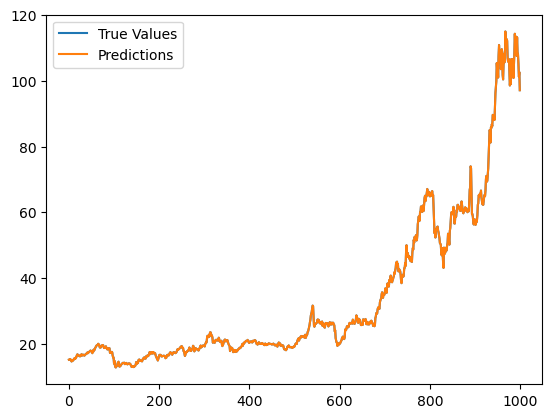

In [97]:
import matplotlib.pyplot as plt
#graph for training data
plt.plot(rawData.iloc[:1000,4].to_numpy(), label='True Values')
plt.plot(endPred, label='Predictions')
plt.legend()
plt.show()

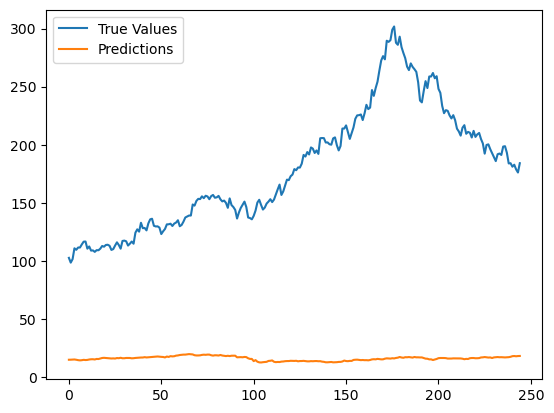

In [99]:
#graph for validation data
plt.plot(rawData.iloc[1007:,4].to_numpy(), label='True Values')
plt.plot(endPredVal, label='Predictions')
plt.legend()
plt.show()
#these both graphs demonstrate val and train set are not split correctly
# the predictions show a great trend for the training data but not for validation set that has a differernt distribution  
# this also shows that the model is way too small to pickup any details on the data (volume and price)